In [1]:
# !pip install missing libraries

In [23]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm
import os

from matplotlib import gridspec

from matplotlib.image import imread
import glob
import cv2

# Cat vs Dog classification dataset

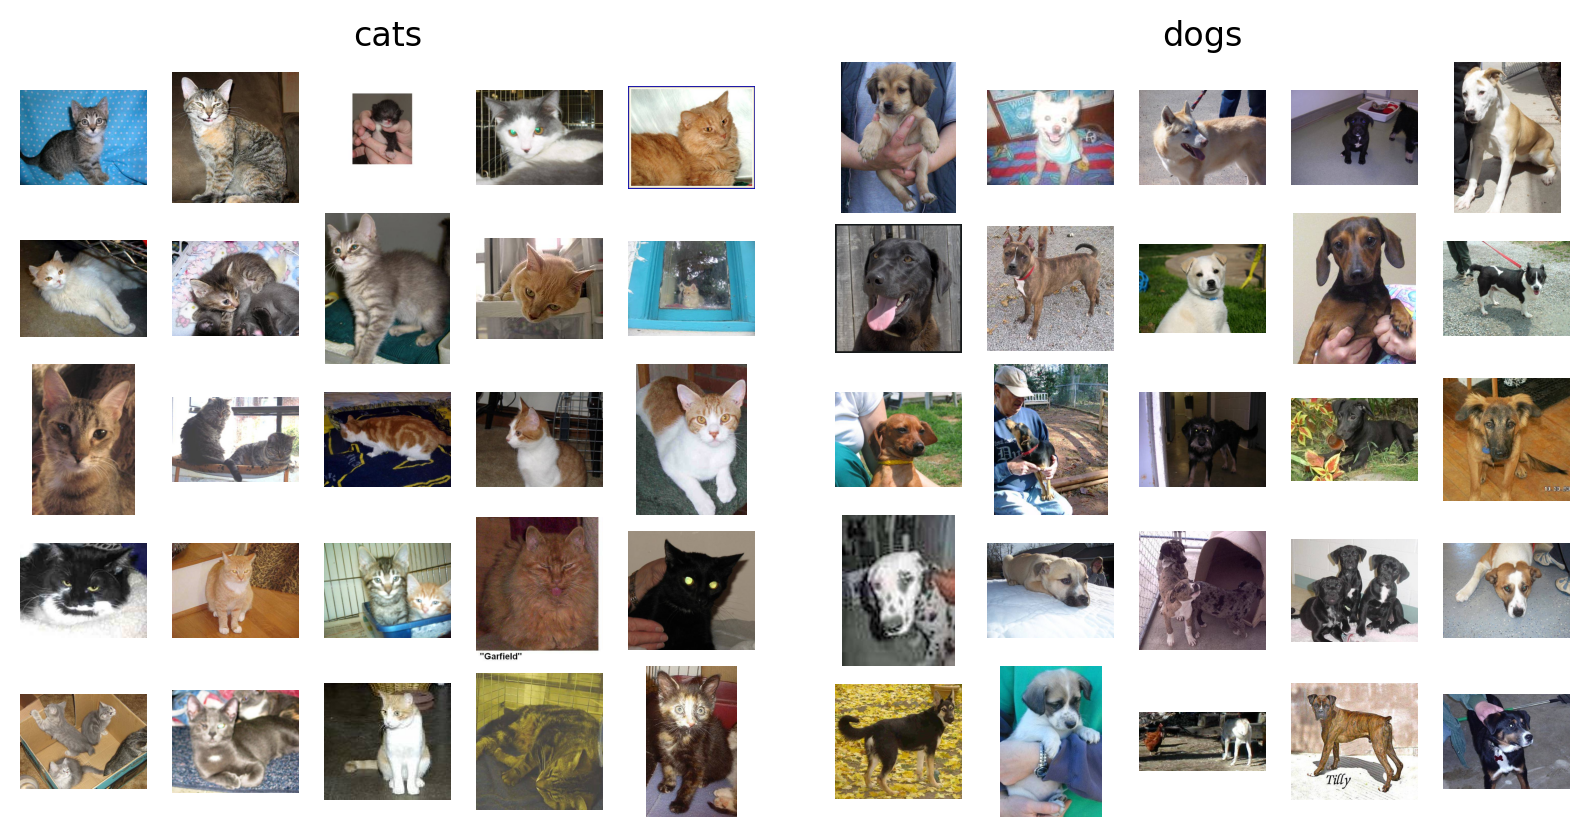

In [22]:
cat_dir = 'dogs_vs_cats/train/cats/'
dog_dir = 'dogs_vs_cats/train/dogs/'

fig = plt.figure(figsize=(10, 5), dpi=200)
gs = gridspec.GridSpec(1, 2, figure=fig, wspace=0.11)

# gridspec from subplot specs
gs_cats = gridspec.GridSpecFromSubplotSpec(5, 5, subplot_spec=gs[0], hspace=0)
gs_dogs = gridspec.GridSpecFromSubplotSpec(5, 5, subplot_spec=gs[1], hspace=0)

# cats
ax = fig.add_subplot(gs[0])
ax.set_title('cats')
ax.axis('off')
for i, cat_path in enumerate(glob.glob(cat_dir + '*.jpg')[:25]):
    ax = fig.add_subplot(gs_cats[i])
    ax.imshow(imread(cat_path))
    ax.axis('off')

# dogs
ax = fig.add_subplot(gs[1])
ax.set_title('dogs')
ax.axis('off')
for i, dog_path in enumerate(glob.glob(dog_dir + '*.jpg')[:25]):
    ax = fig.add_subplot(gs_dogs[i])
    ax.imshow(imread(dog_path))
    ax.axis('off')

# _Pure_ ML Code
_**Still just a few lines of code...**_

In [8]:
# create datasets
class MyDataset(Dataset):
    def __init__(self, dir, nexample=None):
        self.dir = dir
        self.imgs = []
        self.labels = []

        for label in ['cats', 'dogs']:
            for fi, filename in enumerate(glob.glob(os.path.join(dir, label, '*.jpg'))):
                img = cv2.imread(filename)
                img = cv2.resize(img, dsize=(100, 100), interpolation=cv2.INTER_CUBIC)
                self.imgs.append(img)
                if label == 'cats':
                    self.labels.append(torch.FloatTensor([0]))
                else:
                    self.labels.append(torch.FloatTensor([1]))
                if nexample is not None:
                    if fi >= nexample:
                        break
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        img = self.imgs[idx]
        img = torch.FloatTensor(img / 255.0)
        return img, self.labels[idx]

train_ds = MyDataset('dogs_vs_cats/train', nexample=10)
test_ds   = MyDataset('dogs_vs_cats/test', nexample=10)

# create the dataloaders
train_dl = DataLoader(train_ds, batch_size=250, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=5000, shuffle=False)

# the model
class TempNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 22 * 22, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2) # NHWC to NCHW
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = TempNN()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# training loop
for ep in tqdm(range(20)):
    for xb, yb in train_dl:
        optimizer.zero_grad()
        pred = model(xb)
        loss = nn.BCEWithLogitsLoss()(pred, yb)
        loss.backward()
        optimizer.step()

  0%|          | 0/20 [00:00<?, ?it/s]